In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from jupyterplot import ProgressPlot
from tqdm import tqdm, trange

from datetime import datetime, timedelta
import seaborn as sns

In [4]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data = 'data/big_arpafvg.csv', img_dir = 'data/cut_images'):
        initial_data=pd.read_csv(weather_data)
        initial_data = initial_data.drop(columns=['Temp. min gradi C','Temp. med gradi C','Temp. max gradi C','Vento med km/h','Dir. V. max gradi N'])
        #normalize the data
        for col in initial_data.columns:
            if col != 'giorno' and col != 'mese' and col != 'anno':
                initial_data[col] = (initial_data[col] - initial_data[col].mean()) / initial_data[col].std()
        self.weather_data = initial_data
        self.seq_length = 7
        self.target_column_index = -1
        self.date_generated = []

    def __getitem__(self, date):
        #get day month year from date in format dd-mm-yyyy
        day, month, year = date.split('_')
        #get from weather data the row with the same date
        weather_data = self.weather_data[(self.weather_data['giorno'] == int(day)) & (self.weather_data['mese'] == int(month)) & (self.weather_data['anno'] == int(year))]
        weather_data = torch.tensor(weather_data.values[0]) 
        return weather_data
    
    def __len__(self):
        return len(self.weather_data)

    def date_generation(self, start_date, end_date):
        start_date = datetime.strptime(start_date, "%d_%m_%Y")
        end_date = datetime.strptime(end_date, "%d_%m_%Y")
        date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
        #transform the list of datetime objects in a list of strings in format dd-mm-yyyy
        date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]
        self.date_generated=date_generated
        return date_generated
    
    def create_sequence(self, date, len_seq):
        batch_xs =[]
        batch_ys = []
        for elem in date:
            ys = []
            end_of_week = elem.split('_')
            end_of_week = datetime(int(end_of_week[2]), int(end_of_week[1]), int(end_of_week[0])) + timedelta(days = len_seq)
            end_of_week = end_of_week.strftime("%d_%m_%Y")
            imgs, xs =[], []
            week=self.date_generation(elem,end_of_week)
            for day in week:
                b = self.__getitem__(day)
                xs.append(b)

            next = end_of_week.split('_')
            next = datetime(int(next[2]), int(next[1]), int(next[0])) + timedelta(days = 1)
            next = next.strftime("%d_%m_%Y")
            ys.append(self.__getitem__(next)[self.target_column_index])
            xs = np.array(xs)
            ys = np.array(ys)
            xs = torch.from_numpy(xs).float()
            ys = torch.from_numpy(ys).float()
            batch_xs.append(xs)
            batch_ys.append(ys)
                    
        batch_xs = np.array(batch_xs)
        batch_ys = np.array(batch_ys)
        batch_xs = torch.from_numpy(batch_xs).float()
        batch_ys = torch.from_numpy(batch_ys).float()
        return batch_xs, batch_ys

In [5]:
dataset = WeatherDataset()

In [6]:
start_date = datetime.strptime("01_01_2022", "%d_%m_%Y")
end_date = datetime.strptime("15_06_2024", "%d_%m_%Y")
date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]

start_date = datetime.strptime("01_01_2022", "%d_%m_%Y")
end_date = datetime.strptime("15_06_2024", "%d_%m_%Y")
date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]


In [7]:
train_len = int(0.8 * len(date_generated))
test_len = len(date_generated) - train_len
#split the dataset: date_trainset contains the first 80% of the dates, date_testset contains the remaining 20%
date_trainset = date_generated[:train_len]
date_testset = date_generated[train_len:]
print(len(date_trainset))
print(len(date_testset))

716
180


In [8]:
class RainPredictorRNN(nn.Module):
    def __init__(self):
        super(RainPredictorRNN, self).__init__()
        self.input_size = 10 # number of features in the input (weather data)
        self.hidden_size = 4
        self.num_layers = 1
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [9]:
model = RainPredictorRNN()


In [10]:
train_loader = torch.utils.data.DataLoader(dataset=date_trainset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=date_testset, batch_size=4, shuffle=True)

In [11]:
def train(model, dataset, train_loader, test_loader, criterion, optimizer, epochs = 50):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)    
    
    train_loss_epochs = []
    test_loss_epochs = []
    bar = trange(epochs, desc=f"Epoch ?/?, Train Loss: ?, Test Loss: ?")
    for epoch in bar:
        model.train()
        train_losses = []
            
        for date in train_loader:
            xs, ys = dataset.create_sequence(date, 7)
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()
            outputs = model(xs)
            loss = criterion(outputs.squeeze(), ys)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
        train_loss_epochs.append(np.mean(train_losses))
        model.eval()
        test_losses = []
        for date in test_loader: 
            xs, ys = dataset.create_sequence(date, 7)
            xs = xs.to(device)
            ys = ys.to(device)
            outputs = model(xs)
            loss = criterion(outputs.squeeze(), ys)
            test_losses.append(loss.item())
                
        test_loss_epochs.append(np.mean(test_losses))
        bar.set_description(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(test_losses)}")

    return train_loss_epochs, test_loss_epochs

In [12]:
model = RainPredictorRNN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-6, weight_decay=1e-5)

In [14]:
train_losses, test_losses = train(model, dataset, train_loader, test_loader, criterion, optimizer, epochs = 100)

Epoch 100/100, Train Loss: 0.9793766963415306, Test Loss: 1.1489382399453056: 100%|██████████| 100/100 [08:56<00:00,  5.37s/it]


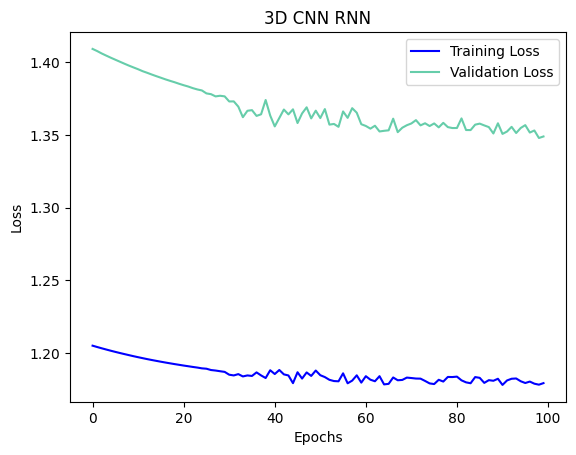

In [18]:
epochs = [epoch for epoch in range(100)]
plt.plot(epochs,train_losses, label='Training Loss', color='blue')
plt.plot(epochs, test_losses, label='Validation Loss', color='mediumaquamarine')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("3D CNN RNN")
plt.savefig("plots_log_rain/rnn_solodata_loss_2.png")
plt.show()

In [19]:
prediction_dataset = WeatherDataset()
prediction_dataset.date_generation('24_12_2023','08_06_2024')
week=prediction_dataset.date_generated
pred_loader=torch.utils.data.DataLoader(week, batch_size = 1, shuffle = False)

In [20]:
def predict(model, pred_loader, dataset):
    predictions=[]
    predicted_days=[]
    real_rains=[]
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model=model.to(device)
    for date in pred_loader:  
            xs, ys = dataset.create_sequence(date, 7)
            xs = xs.to(device)
            ys = ys.to(device)
            output = model(xs)
            output=output.cpu()
            predictions.append(output.detach().numpy())
            predicted_day = date[0].split('_')
            predicted_day = datetime(int(predicted_day[2]), int(predicted_day[1]), int(predicted_day[0])) + timedelta(days = 8)
            predicted_day = predicted_day.strftime("%d_%m_%Y")
            predicted_days.append(predicted_day)
            real_rain = dataset[predicted_day][-1]
            real_rains.append(real_rain)
            
    return predicted_days, predictions, real_rains

In [21]:
predicted_days, predictions, real_rain= predict(model, pred_loader, prediction_dataset)

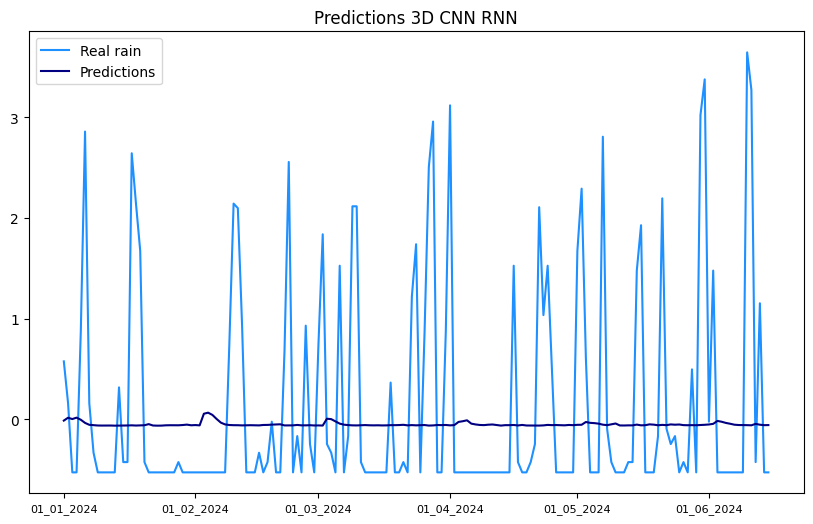

In [22]:
predicted_days = np.array(predicted_days)
real_rain = np.array(real_rain)

date_to_display = ['01_01_2024', '01_02_2024', '01_03_2024', '01_04_2024', '01_05_2024', '01_06_2024']

indices_to_display = [np.where(predicted_days == date)[0][0] for date in date_to_display if date in predicted_days]

plt.figure(figsize=(10, 6))
sns.lineplot(x=predicted_days, y=real_rain, label='Real rain', color='dodgerblue')
sns.lineplot(x=predicted_days, y=np.array(predictions).squeeze(), label='Predictions', color='navy')

plt.xticks(predicted_days[indices_to_display], date_to_display, fontsize=8)

plt.title('Predictions RNN')
plt.legend()
plt.savefig("plots_log_rain/rnn_solodata_prediction_2.png")
plt.show()

In [ ]:
predictions = np.array(predictions).squeeze()

real_rain_tensor = torch.tensor(real_rain, dtype=torch.float32)
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)

mse_loss = torch.nn.MSELoss()
rmse = torch.sqrt(mse_loss(predictions_tensor, real_rain_tensor))

print(f"RMSE: {rmse.item()}")